In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import cKDTree
from scipy.sparse import csr_matrix
import warnings

In [3]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="is_categorical_dtype")

In [4]:
# Read the data
data = pd.read_csv('Data/Final/Dataset.csv')
london_shp = gpd.read_file('Data/Revised/Geography/MSOA/London_2021.shp')

# Merge the data
data['Code_2021'] = data['Code_2021'].astype(str)
london_shp['msoa21cd'] = london_shp['msoa21cd'].astype(str)
gdf = london_shp.merge(data, left_on='msoa21cd', right_on='Code_2021', how='inner')

print("GDF shape:", gdf.shape)
print("GDF columns:", gdf.columns)

GDF shape: (193588, 20)
GDF columns: Index(['hclnm', 'hclnmw', 'label', 'msoa21cd', 'msoa21nm', 'name', 'geometry',
       'Code_2020', 'Label_2020', 'Code_2021', 'Label_2021', 'IMD_Before',
       'IMD_After', 'IMD_Change', 'Health_Before', 'Health_After',
       'Health_Change', 'Count', 'IMD_Total', 'Health_Total'],
      dtype='object')


X shape before adding lag variables: (193588, 3)
X columns before adding lag variables: Index(['IMD_Before', 'IMD_After', 'Count'], dtype='object')
X shape after adding lag variables: (193588, 6)
X columns after adding lag variables: Index(['IMD_Before', 'IMD_After', 'Count', 'IMD_Before_lag', 'IMD_After_lag',
       'Count_lag'],
      dtype='object')
NaN values in features:
IMD_Before        0
IMD_After         0
Count             0
IMD_Before_lag    0
IMD_After_lag     0
Count_lag         0
dtype: int64
X_imputed shape: (193588, 6)
X_imputed columns: Index(['IMD_Before', 'IMD_After', 'Count', 'IMD_Before_lag', 'IMD_After_lag',
       'Count_lag'],
      dtype='object')
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     21005
           1       1.00      1.00      1.00     17713

    accuracy                           1.00     38718
   macro avg       1.00      1.00      1.00     38718
weighted avg       1.00      1.00      1.00    

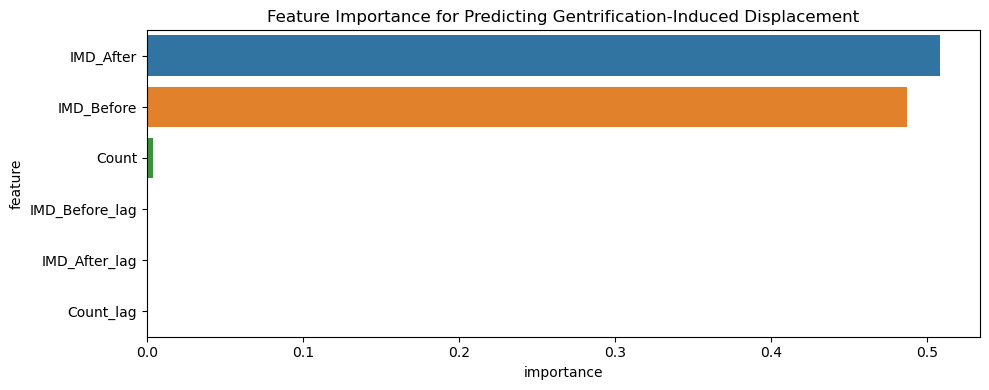

In [7]:
# Create a memory-efficient sparse spatial weights matrix
def create_sparse_spatial_weights(gdf, k=5):
    centroids = gdf.geometry.centroid
    coords = np.column_stack((centroids.x, centroids.y))
    tree = cKDTree(coords)
    distances, indices = tree.query(coords, k=k+1)  # +1 because the first is itself
    
    rows = np.repeat(np.arange(len(gdf)), k)
    cols = indices[:, 1:].flatten()  # Skip the first (itself)
    distances = distances[:, 1:].flatten()

    # Handle zero distances to avoid division by zero errors
    distances[distances == 0] = np.inf
    weights = 1 / distances
    weights[np.isinf(weights)] = 0  # Replace infinity values with zero
    
    # Normalize weights and handle divisions by zero
    weight_sums = np.repeat(np.sum(weights.reshape(-1, k), axis=1), k)
    weight_sums[weight_sums == 0] = 1  # Avoid division by zero by setting sum to 1 where it's zero
    weights = weights / weight_sums

    return csr_matrix((weights, (rows, cols)), shape=(len(gdf), len(gdf)))

# Create sparse spatial weights matrix
spatial_weights = create_sparse_spatial_weights(gdf)

# Prepare features
features = ['IMD_Before', 'IMD_After', 'Count']
X = gdf[features].copy()

print("X shape before adding lag variables:", X.shape)
print("X columns before adding lag variables:", X.columns)

# Add spatial lag variables
lag_features = {}
for feature in features:
    lag_values = spatial_weights.dot(gdf[feature].values)
    lag_features[f'{feature}_lag'] = lag_values

# Add lag features to X
X = pd.concat([X, pd.DataFrame(lag_features)], axis=1)

print("X shape after adding lag variables:", X.shape)
print("X columns after adding lag variables:", X.columns)

# Check NaN values and handle columns that are entirely NaN
print("NaN values in features:")
print(X.isnull().sum())

# For columns that are entirely NaN, fill with 0
for col in X.columns:
    if X[col].isna().all():
        X[col] = 0  # Replace entirely NaN columns with zero or another appropriate value

# Handle NaN values
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

print("X_imputed shape:", X_imputed.shape)
print("X_imputed columns:", X_imputed.columns)

# Define target variable: IMD_Change > 0 indicates potential gentrification-induced displacement
y = (gdf['IMD_Change'] > 0).astype(int)

# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 4))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance for Predicting Gentrification-Induced Displacement')
plt.tight_layout()

# Export the image
output_path = "Data/Feature.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)

plt.show()

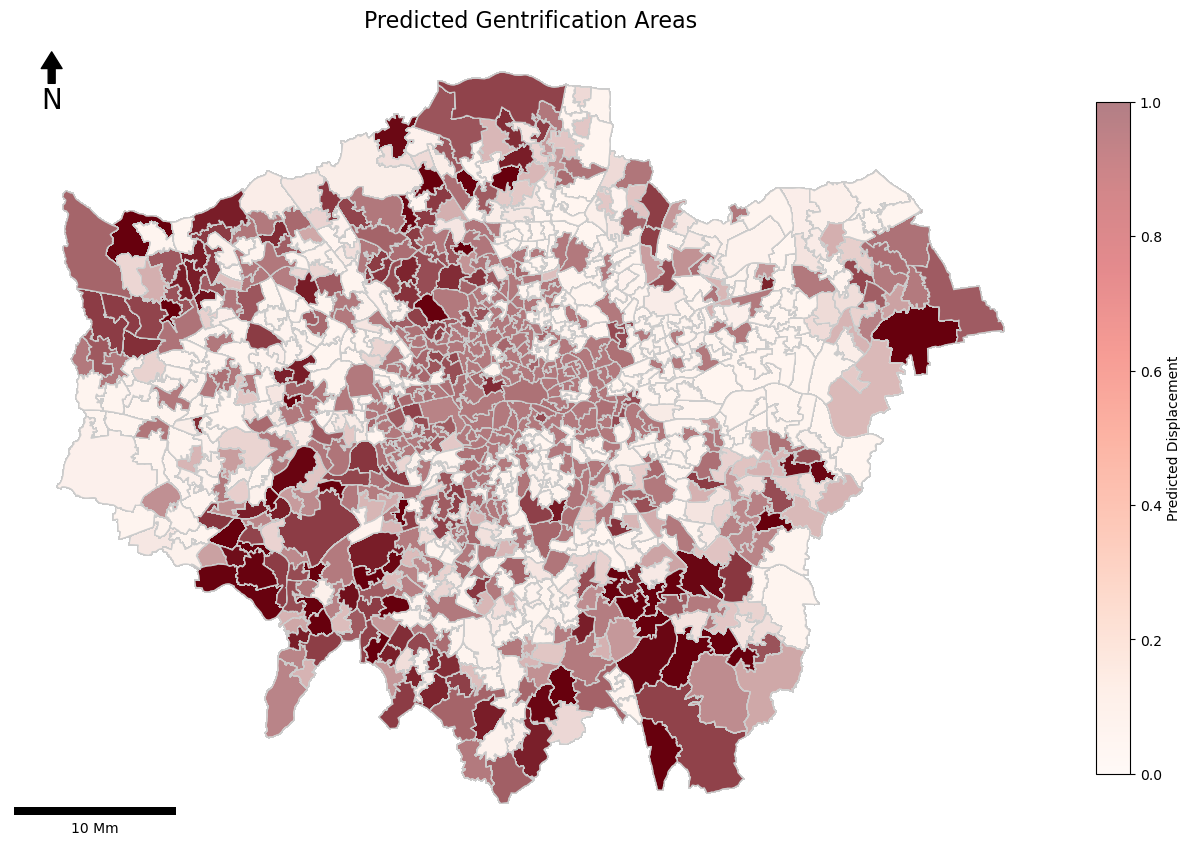

In [6]:
# Predict and visualize results
gdf['predicted_displacement'] = rf_model.predict(scaler.transform(X_imputed))

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import Normalize, ListedColormap

# Set global font to DejaVu Sans, similar to Arial
plt.rcParams['font.family'] = 'DejaVu Sans'

# Define red colormap and adjust alpha
base_cmap = plt.cm.Reds
cmap = ListedColormap(base_cmap(np.linspace(0, 1, 256)))  # Get base red colormap
cmap.colors[:, -1] = 0.5  # Adjust transparency to 0.5 to match map colors

# Plot the predicted gentrification-induced displacement areas
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Use red colormap and ensure consistent transparency
gdf.plot(
    column='predicted_displacement',
    cmap=cmap,
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=False
)

# Add title and turn off axis
ax.set_title('Predicted Gentrification Areas', fontsize=16)
ax.axis('off')

# Add a north arrow
x, y, arrow_length = 0.04, 0.98, 0.06
ax.annotate('N', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20, xycoords='axes fraction', zorder=5)

# Add a scale bar, units in km, with a transparent background
scalebar = ScaleBar(dx=1, units="km", location='lower left', scale_loc='bottom', length_fraction=0.2, box_alpha=0)
ax.add_artist(scalebar)

# Manually add color bar to ensure consistent colors
norm = Normalize(vmin=gdf['predicted_displacement'].min(), vmax=gdf['predicted_displacement'].max())
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Dummy array for color bar
cbar = fig.colorbar(sm, ax=ax, fraction=0.03, pad=0.04)
cbar.set_label('Predicted Displacement')

# Adjust layout to align color bar, scale bar, and map
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

# Export the image
output_path = "Predicted_Displacement_Map_Consistent.png"
plt.savefig(output_path, dpi=300, bbox_inches='tight', transparent=True)

# Show the map
plt.show()